# Notebook for adding in TFs

Alyssa's 3/4/2019

- 3/7/2019 Fixed loss function to mask missing values
- 3/7/2017 Started to implement rotating cell types


3/14/2019
- implement 1 hot encoding for features
- test number of cells v prediction

# Imports

In [1]:
import collections
import datetime

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging
from numba import cuda

from scipy import stats

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft
import datetime
import sys

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


In [2]:
import logging

# get TF logger
log = logging.getLogger('tensorflow')
log.setLevel(logging.INFO)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
fh = logging.FileHandler('/data/akmorrow/tensorflow.log')
fh.setLevel(logging.INFO)
fh.setFormatter(formatter)
log.addHandler(fh)

In [3]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())
exec(open("./generators.py").read())
exec(open("./models.py").read())


# Make sure GPU is available

In [4]:
# check GPUs are available
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
gpus = [x for x in local_device_protos if x.device_type == 'GPU']
print(gpus)
assert(len(gpus) > 0)


[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11914978919
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 13366451845427221081
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:81:00.0, compute capability: 6.1"
]


# Define Paths for this user

In [182]:
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
# Required in constants.py
# _ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

# # where training data is stored
# deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"

# del _ENCODE_DATA_PREFIX
# del deepsea_path

feature_path = '../data/feature_name'

output_path = '/home/eecs/akmorrow/epitome/out/Epitome'

data_path = "/data/akmorrow/epitome_data/deepsea_labels_train/"

# Load Data

### Load DeepSEA data

In [7]:
# generated from original data by save_deepsea_label_data(deepsea_path) in functions.py
train_data, valid_data, test_data = load_deepsea_label_data(data_path)

In [8]:
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(919, 408000) (919, 4455024) (919, 455024)


# Validation and Test Cell Types

## Get matrix of cell types and assays

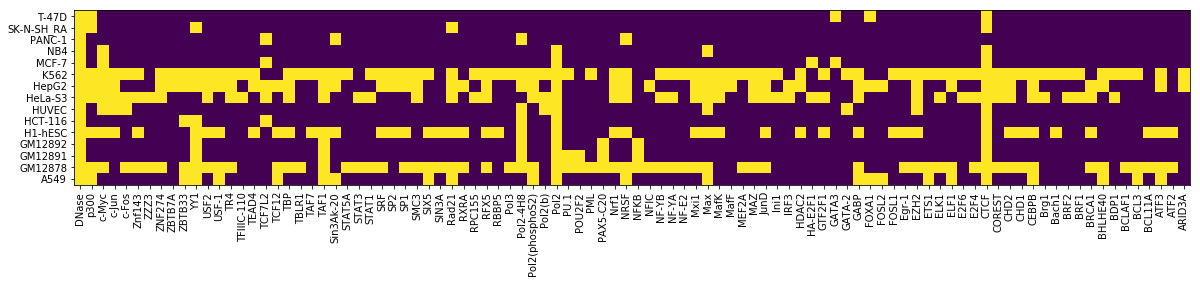

In [191]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path=feature_path, 
                                  eligible_assays = None,
                                  eligible_cells = None, min_cells_per_assay = 2, min_assays_per_cell=5)
        
inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)


In [12]:
test_celltypes = [] # most available cell types

# Run the Model

In [196]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())
exec(open("./generators.py").read())
exec(open("./models.py").read())

radii = [1,3,10,30]
model = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            test_celltypes,
            gen_from_peaks, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            radii=radii)
model.train(20000)
model.save("/data/akmorrow/epitome_data/saved_models/model__%s.ckpt" % datetime.datetime.now().strftime("%Y_%m_%d__%H_%M"))

eval cell types ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment
INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.06525384
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.44296814492908354
INFO:tensorflow:Our micro AUC:     0.44296814492908354
INFO:tensorflow:
INFO:tensorflow:2000 0.011263571
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.7024534117877296
INFO:tensorflow:Our micro AUC:     0.7024534117877296
INFO:tensorflow:
INFO:tensorflow:3000 0.00738411
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.7788653642971068
INFO:tensorflow:Our micro AUC:     0.7788653642971068
INFO:tensorflow:
INFO:tensorflow:4000 0.0063818707
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8737659569666918
INFO:tensorflow:Our micro AUC:     0.8737659569666918
INFO:tensorflow:
INFO:tensorflow:5000 0.09077248
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8682443143392559
INFO:tensorflow:Our micro AUC:     0.8682443143392559
INFO

In [197]:
 preds, truth, assay_dict, microAUC, macroAUC, _ = model.test(test_data["y"].shape[1], iter_, log=True)

Exception: No data exists for <tensorflow.python.data.ops.iterator_ops.Iterator object at 0x7f01647c6278>. Use function test_from_generator() if you want to create a new iterator.

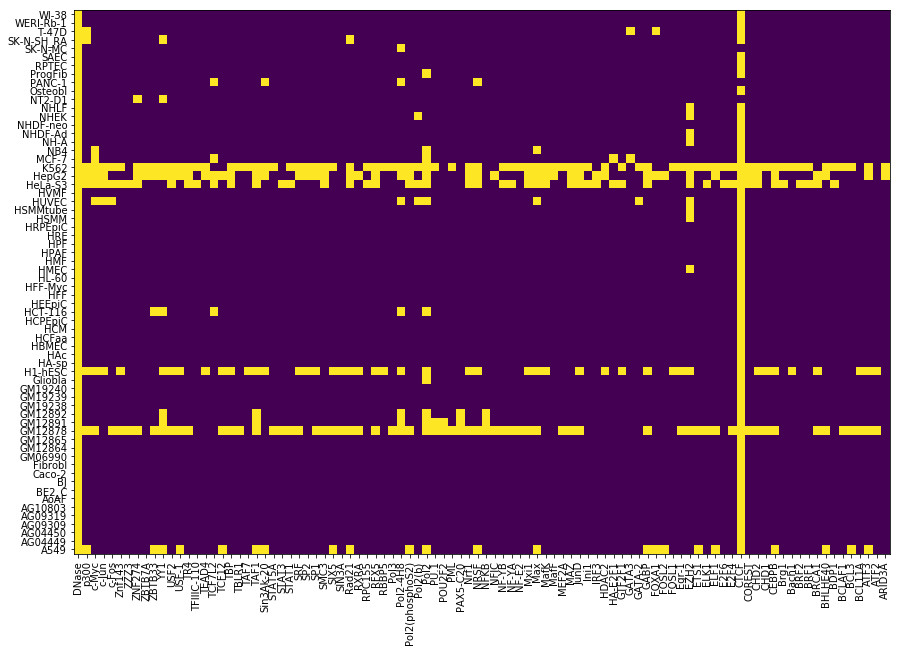

In [119]:
# matrix is cell types by factors, contains indices in feature vector
# 172 factors.
all_matrix, all_cellmap, all_assaymap = get_assays_from_feature_file(feature_path=feature_path,eligible_assays = list(assaymap),
                                  eligible_cells = None, min_cells_per_assay = 2, min_assays_per_cell=2)


inv_assaymap = {v: k for k, v in all_assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(all_assaymap)), rotation = 90)
ax.set_xticklabels(all_assaymap.keys())
plt.yticks(np.arange(len(all_cellmap)))
ax.set_yticklabels(all_cellmap.keys())
plt.imshow(all_matrix!=-1)

assert(list(assaymap) == list(all_assaymap))

In [193]:
exec(open("./generators.py").read())

assaylist = list(assaymap)
assaylist.remove('DNase')

df_AUC = pd.DataFrame([],
                   columns= ["CellType"] + assaylist + ["AUC_Average_Macro", "AUC_Average_Micro"])
df_PR = pd.DataFrame([],
                   columns= ["CellType"] + assaylist + ["PR_Average"])
    
for test_celltype in all_cellmap:
    print(test_celltype)
    
    eval_cell_types = list(cellmap).copy()
    
    # if test_celltype is in eval_cell_types, replace it with something else
    if (test_celltype in eval_cell_types):
        if (test_celltype == "PANC-1"):
            new_eval_celltype = "NT2-D1" # TODO maybe don't hardcode
        else:
            new_eval_celltype = "PANC-1" # TODO maybe don't hardcode
        
        print("removing %s from eval_celltypes and replacing with %s" % (test_celltype, new_eval_celltype))
        eval_cell_types.remove(test_celltype)
        eval_cell_types.append(new_eval_celltype)
    
    _, iter_ = generator_to_one_shot_iterator(make_dataset(test_data, 
                                                   [test_celltype], 
                                                   eval_cell_types,
                                                   gen_from_peaks, 
                                                   all_matrix,
                                                   assaymap,
                                                   all_cellmap,
                                                   radii = model.radii, mode = Dataset.TEST),
                                                       model.batch_size, 1, model.prefetch_size)
                
    
    preds, truth, assay_dict, microAUC, macroAUC, _ = model.test_from_generator(test_data["y"].shape[1], iter_, log=True)
    
    parsed_AUC = list(map(lambda x: x[1]["AUC"], assay_dict.items()))
    parsed_PR = list(map(lambda x: x[1]["auPRC"], assay_dict.items()))
    
    # get auPRC mean
    average_auPRC = np.nanmean(parsed_PR)

    results_AUC = pd.DataFrame([[test_celltype] + parsed_AUC +  [microAUC, macroAUC]],
                       columns=["CellType"] + assaylist + ["AUC_Average_Macro", "AUC_Average_Micro"])
    
    results_PR = pd.DataFrame([[test_celltype] + parsed_PR +  [average_auPRC]],
                       columns=["CellType"] + assaylist + ["PR_Average"])
    
    
    df_AUC = df_AUC.append(results_AUC)
    df_PR  = df_PR.append(results_PR)
    
    
    
df_AUC.to_pickle(os.path.join(output_path, "Epitome_AUC.pickle"))

df_PR.to_pickle(os.path.join(output_path, "Epitome_PR.pickle"))


WI-38
using ['WI-38'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9050847457627119
INFO:tensorflow:Our micro AUC:     0.9050847457627119
WERI-Rb-1
using ['WERI-Rb-1'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9682539682539683
INFO:tensorflow:Our micro AUC:     0.9682539682539683
T-47D
removing T-47D from eval_celltypes and replacing with PANC-1
using ['T-47D'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
SK-N-SH_RA
removing SK-N-SH_RA from eval_celltypes and replacing with PANC-1
using ['SK-N-SH_RA'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.6397159057523943
INFO:tensorflow:Our micro AUC:     0.6397159057523943
SK-N-MC
using ['SK-N-MC'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     nan
INFO:tensorflow:Our micro AUC:     nan
SAEC
using ['SAEC'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tenso

HepG2
removing HepG2 from eval_celltypes and replacing with PANC-1
using ['HepG2'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.845734539188494
INFO:tensorflow:Our micro AUC:     0.845734539188494
HeLa-S3
removing HeLa-S3 from eval_celltypes and replacing with PANC-1
using ['HeLa-S3'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9350683237157453
INFO:tensorflow:Our micro AUC:     0.9350683237157453


HVMF
using ['HVMF'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
HUVEC
removing HUVEC from eval_celltypes and replacing with PANC-1
using ['HUVEC'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9803105212941278
INFO:tensorflow:Our micro AUC:     0.9803105212941278
HSMMtube
using ['HSMMtube'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.7580645161290323
INFO:tensorflow:Our micro AUC:     0.7580645161290323
HSMM
using ['HSMM'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9672131147540983
INFO:tensorflow:Our micro AUC:     0.9672131147540983
HRPEpiC
using ['HRPEpiC'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9617486338797814
INFO:tensorflow:Our micro AUC:     0.9617486338797814
HRE
using ['HRE'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
HPF
using ['HPF'] as labe

Gliobla
using ['Gliobla'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9173387096774194
INFO:tensorflow:Our micro AUC:     0.9173387096774194
GM19240
using ['GM19240'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
GM19239
using ['GM19239'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
GM19238
using ['GM19238'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.814207650273224
INFO:tensorflow:Our micro AUC:     0.814207650273224
GM12892
removing GM12892 from eval_celltypes and replacing with PANC-1
using ['GM12892'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9737726192429962
INFO:tensorflow:Our micro AUC:     0.9737726192429962
GM12891
removing GM12891 from eval_celltypes and replacing with PANC-1
using ['GM12891'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.95291292085

GM12865
using ['GM12865'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
GM12864
using ['GM12864'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.9919354838709677
INFO:tensorflow:Our micro AUC:     0.9919354838709677
GM06990
using ['GM06990'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
Fibrobl
using ['Fibrobl'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.8306010928961748
INFO:tensorflow:Our micro AUC:     0.8306010928961748
Caco-2
using ['Caco-2'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
BJ
using ['BJ'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     1.0
INFO:tensorflow:Our micro AUC:     1.0
BE2_C
using ['BE2_C'] as labels for mode Dataset.TEST
INFO:tensorflow:Our macro AUC:     0.7844827586206896
INFO:tensorflow:Our micro AU

In [63]:
preds, truth, assay_dict, microAUC, macroAUC, _ = model.test(40000, mode = Dataset.TEST, log=True)

OutOfRangeError: End of sequence
	 [[node IteratorGetNext (defined at <string>:112)  = IteratorGetNext[output_shapes=[[?,2,1456], [?,95], [?,95]], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorFromStringHandleV2)]]
	 [[{{node dense_1/Tensordot/GatherV2_1/_29}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_50_dense_1/Tensordot/GatherV2_1", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'IteratorGetNext', defined at:
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-259579f2f3bb>", line 18, in <module>
    radii=radii)
  File "<string>", line 396, in __init__
  File "<string>", line 112, in __init__
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 421, in get_next
    name=name)), self._output_types,
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 2069, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[node IteratorGetNext (defined at <string>:112)  = IteratorGetNext[output_shapes=[[?,2,1456], [?,95], [?,95]], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](IteratorFromStringHandleV2)]]
	 [[{{node dense_1/Tensordot/GatherV2_1/_29}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_50_dense_1/Tensordot/GatherV2_1", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [175]:
df_AUC

,CellType,p300,c-Myc,c-Jun,c-Fos,Znf143,ZZZ3,ZNF274,ZBTB7A,ZBTB33,...,BHLHE40,BDP1,BCLAF1,BCL3,BCL11A,ATF3,ATF2,ARID3A,AUC_Average_Macro,AUC_Average_Micro
0,WI-38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905085,0.905085


In [198]:
# quit session and deallocate GPU memory
model.sess.close()


cuda.select_device(0)
cuda.close()

# look for correlation between cell type counts and performace

In [28]:
matrix2 = np.copy(matrix)
# remove test celltypes
matrix2 = np.delete(matrix2, cellmap[test_celltypes[0]], 0)
matrix3 = np.copy(matrix)
matrix3 = np.delete(matrix3, cellmap[test_celltypes[0]], 0)

In [29]:


matrix2[matrix2 >= 0]  = 1
matrix2[matrix2 == -1]  = 0
tmp = np.sum(matrix2, axis=0)

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/matplotlib/text.py:2148: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


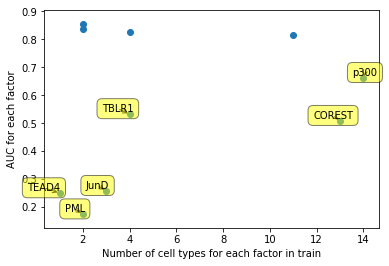

In [32]:
t = [(k, v['AUC']) for (k, v) in assay_dict.items()]
zipped = zip(tmp, t)

k = list(filter(lambda x: not np.isnan(x[1][1]),  zipped))

x = list(map(lambda x: x[0], k))
y = list(map(lambda x: x[1][1], k))


fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Number of cell types for each factor in train')
ax.set_ylabel('AUC for each factor')

for i, txt in enumerate(k):
    label = txt[1][0]
    if (y[i] < 0.7):
        ax.annotate(label, (x[i], y[i]),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))



In [107]:
# for each assay, count positives in train
results_dict = {}


for (assay, res) in assay_dict.items():
    if (not np.isnan(res['AUC'])):
        x = matrix3[:,assaymap[assay]]
        filtered = x[np.where(x >= 0)[0]]

        sum_ = np.sum(train_data["y"][filtered,:])
        results_dict[assay] = (sum_, res['AUC'])




In [108]:
macroAUC

0.8608675037689738

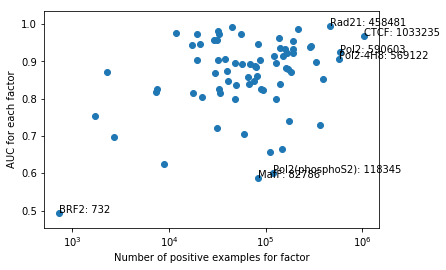

In [109]:

x = [v[0] for (k, v) in results_dict.items()]
y = [v[1] for (k, v) in results_dict.items()]

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Number of positive examples for factor')
ax.set_ylabel('AUC for each factor')
ax.set_xscale('symlog')

for i, txt in enumerate(results_dict.items()):
    label = txt[0]
    if (y[i] < 0.6 or x[i]>400000):
        ax.annotate("%s: %i" % (label, x[i]), (x[i], y[i]),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

# Results

- 96 TFs test GM12878 0.8819470290234287
- 96 TFS test K562    0.8340156671491048
- 96 TFS test K562 with filtering 0.7928056830435212
- 96 TFS test K562 (One hot encoding) 0.8608675037689738 (seems to help some)



Does it help to use "one hot" encoding? (yes)
Remove TFs with too few positives

In [983]:
model.save("/data/akmorrow/epitome_data/saved_models/test_model_full_2.ckpt")


INFO:tensorflow:Model saved in path: /data/akmorrow/epitome_data/saved_models/test_model_full_2.ckpt


# Restore Model

In [241]:
model2  = MLP(4, [100, 100, 100, 50], 
            tf.tanh, 
            train_data, 
            valid_data, 
            test_data, 
            test_celltypes,
            gen_from_peaks, 
            matrix,
            assaymap,
            cellmap,
            shuffle_size=2, 
            radii=[1,3,10,30])
model2.restore("/data/akmorrow/epitome_data/saved_models/test_model_full_2.ckpt")

INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [243]:
x = model2.test(40000, mode = Dataset.TEST, log=True)

INFO:tensorflow:Failed to calculate macro AUC
INFO:tensorflow:Failed to calculate micro AUC
2019-03-05 11:53:43.136928 0 DNase
INFO:tensorflow:2019-03-05 11:53:43.137011: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.494	avPR:0.014	GINI:0.653
INFO:tensorflow:c-Myc:	AUC:0.567	avPR:0.004	GINI:0.697
INFO:tensorflow:c-Jun:	AUC:0.470	avPR:0.013	GINI:0.685
INFO:tensorflow:c-Fos:	AUC:0.538	avPR:0.014	GINI:0.497
INFO:tensorflow:Znf143:	AUC:0.458	avPR:0.006	GINI:0.447


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:ZZZ3:	AUC:nan	avPR:nan	GINI:0.429
INFO:tensorflow:ZNF274:	AUC:0.509	avPR:0.001	GINI:0.463


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:ZBTB7A:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:ZBTB33:	AUC:0.600	avPR:0.003	GINI:0.496
INFO:tensorflow:YY1:	AUC:0.550	avPR:0.003	GINI:0.241
INFO:tensorflow:USF2:	AUC:0.459	avPR:0.003	GINI:0.726
INFO:tensorflow:USF-1:	AUC:0.460	avPR:0.004	GINI:0.326
INFO:tensorflow:TR4:	AUC:0.478	avPR:0.002	GINI:0.695


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:TFIIIC-110:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:TEAD4:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:TCF7L2:	AUC:0.561	avPR:0.004	GINI:0.758
INFO:tensorflow:TCF12:	AUC:0.501	avPR:0.012	GINI:0.455
INFO:tensorflow:TBP:	AUC:0.547	avPR:0.009	GINI:0.335
INFO:tensorflow:TBLR1:	AUC:0.518	avPR:0.009	GINI:0.516


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:TAF7:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:TAF1:	AUC:0.604	avPR:0.005	GINI:0.288
INFO:tensorflow:Sin3Ak-20:	AUC:0.505	avPR:0.004	GINI:0.573
INFO:tensorflow:SUZ12:	AUC:0.506	avPR:0.004	GINI:0.587
INFO:tensorflow:STAT5A:	AUC:0.558	avPR:0.013	GINI:0.319
INFO:tensorflow:STAT3:	AUC:0.533	avPR:0.006	GINI:0.527
INFO:tensorflow:STAT1:	AUC:0.358	avPR:0.000	GINI:0.384
INFO:tensorflow:SRF:	AUC:0.547	avPR:0.002	GINI:0.525


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:SP2:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:SP1:	AUC:0.563	avPR:0.008	GINI:0.366
INFO:tensorflow:SMC3:	AUC:0.689	avPR:0.049	GINI:0.521
INFO:tensorflow:SIX5:	AUC:0.579	avPR:0.004	GINI:0.453
INFO:tensorflow:SIN3A:	AUC:0.567	avPR:0.006	GINI:0.346
INFO:tensorflow:Rad21:	AUC:0.639	avPR:0.017	GINI:0.458
INFO:tensorflow:RXRA:	AUC:0.435	avPR:0.000	GINI:0.416


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:RPC155:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:RFX5:	AUC:0.367	avPR:0.001	GINI:0.502


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:RBBP5:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Pol3:	AUC:nan	avPR:nan	GINI:0.499
INFO:tensorflow:Pol2-4H8:	AUC:0.548	avPR:0.020	GINI:0.499
INFO:tensorflow:Pol2(phosphoS2):	AUC:0.529	avPR:0.003	GINI:0.503
INFO:tensorflow:Pol2(b):	AUC:0.431	avPR:0.004	GINI:0.285
INFO:tensorflow:Pol2:	AUC:0.511	avPR:0.005	GINI:0.483
INFO:tensorflow:PU.1:	AUC:0.487	avPR:0.016	GINI:0.435
INFO:tensorflow:POU2F2:	AUC:0.491	avPR:0.012	GINI:0.432
INFO:tensorflow:PML:	AUC:0.515	avPR:0.016	GINI:0.302
INFO:tensorflow:PAX5-C20:	AUC:0.492	avPR:0.012	GINI:0.943
INFO:tensorflow:Nrf1:	AUC:0.436	avPR:0.002	GINI:0.440
INFO:tensorflow:NRSF:	AUC:0.535	avPR:0.007	GINI:0.642
INFO:tensorflow:NFKB:	AUC:0.432	avPR:0.009	GINI:0.462
INFO:tensorflow:NFIC:	AUC:0.527	avPR:0.029	GINI:0.443
INFO:tensorflow:NF-YB:	AUC:0.486	avPR:0.005	GINI:0.494
INFO:tensorflow:NF-YA:	AUC:0.460	avPR:0.001	GINI:0.664


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:NF-E2:	AUC:nan	avPR:nan	GINI:0.554
INFO:tensorflow:Mxi1:	AUC:0.495	avPR:0.010	GINI:0.303
INFO:tensorflow:Max:	AUC:0.477	avPR:0.004	GINI:0.279


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:MafK:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:MafF:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:MEF2A:	AUC:0.422	avPR:0.009	GINI:0.488
INFO:tensorflow:MAZ:	AUC:0.505	avPR:0.008	GINI:0.307
INFO:tensorflow:JunD:	AUC:0.428	avPR:0.001	GINI:0.288


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Ini1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:IRF3:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:HDAC2:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:HA-E2F1:	AUC:0.509	avPR:0.009	GINI:0.839


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:GTF2F1:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:GATA3:	AUC:0.472	avPR:0.002	GINI:0.414
INFO:tensorflow:GATA-2:	AUC:0.472	avPR:0.021	GINI:0.524
INFO:tensorflow:GABP:	AUC:0.509	avPR:0.006	GINI:0.336
INFO:tensorflow:FOXA1:	AUC:0.496	avPR:0.002	GINI:0.870
INFO:tensorflow:FOSL2:	AUC:0.538	avPR:0.019	GINI:0.559


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:FOSL1:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:Egr-1:	AUC:0.555	avPR:0.011	GINI:0.408
INFO:tensorflow:EZH2:	AUC:0.553	avPR:0.004	GINI:0.384
INFO:tensorflow:ETS1:	AUC:0.476	avPR:0.001	GINI:0.785
INFO:tensorflow:ELK1:	AUC:0.479	avPR:0.001	GINI:0.577
INFO:tensorflow:ELF1:	AUC:0.567	avPR:0.007	GINI:0.408


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:E2F6:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:E2F4:	AUC:0.572	avPR:0.001	GINI:0.614
INFO:tensorflow:CTCF:	AUC:0.519	avPR:0.018	GINI:0.420
INFO:tensorflow:COREST:	AUC:0.504	avPR:0.001	GINI:0.287
INFO:tensorflow:CHD2:	AUC:0.489	avPR:0.007	GINI:0.369
INFO:tensorflow:CHD1:	AUC:0.566	avPR:0.006	GINI:0.216
INFO:tensorflow:CEBPB:	AUC:0.512	avPR:0.015	GINI:0.519


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Brg1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:Bach1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BRF2:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BRF1:	AUC:nan	avPR:nan	GINI:nan


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BRCA1:	AUC:nan	avPR:nan	GINI:0.674
INFO:tensorflow:BHLHE40:	AUC:0.503	avPR:0.004	GINI:0.342


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


INFO:tensorflow:BDP1:	AUC:nan	avPR:nan	GINI:nan
INFO:tensorflow:BCLAF1:	AUC:0.484	avPR:0.005	GINI:0.748
INFO:tensorflow:BCL3:	AUC:0.497	avPR:0.008	GINI:0.689
INFO:tensorflow:BCL11A:	AUC:0.548	avPR:0.012	GINI:0.671
INFO:tensorflow:ATF3:	AUC:0.545	avPR:0.003	GINI:0.450
INFO:tensorflow:ATF2:	AUC:0.521	avPR:0.024	GINI:0.769
